In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as mets
import timeit
from toolz import pipe as p

import utils

In [2]:
from importlib import reload
reload(utils)

<module 'utils' from 'C:\\Users\\jod204\\projects\\mesh-project\\utils.py'>

In [3]:
cr_data = pd.read_csv('pubmed_cr_abstracts.csv')

In [4]:
cr_data.shape

(1293, 5)

In [5]:
sum(cr_data.label)

598

In [6]:
sum(1-cr_data.label)

695

In [7]:
cr_data.columns

Index(['pmid', 'yr', 'title', 'abstract', 'label'], dtype='object')

Merge title and abstract

In [8]:
type(cr_data.pmid[0])

numpy.int64

In [9]:
project_data = cr_data[['pmid', 'label']]
project_data['txt'] = cr_data.title + ' . ' + cr_data.abstract

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
project_data.shape

(1293, 3)

In [11]:
project_data.head()


,pmid,label,txt
0,21218043,1,Acute liver failure associated with occupation...
1,26000001,0,A successful pregnancy during the treatment of...
2,23792523,1,"AST 17600 U/l after liver transplantation, wha..."
3,25034585,0,[Pulmonary benign metastasizing leiomyoma: a c...
4,25026126,0,Two novel mutations in acid a-glucosidase gene...


In [12]:
len(project_data.loc[0, 'txt'])

1076

In [13]:
len(project_data.txt[0])

1076

In [14]:
cr_data.head()
print(len(cr_data.loc[0, 'title']))
print(len(cr_data.loc[0, 'abstract']))

81
992


## Clean Data

In [15]:
clean_data = project_data.dropna()

In [16]:
58 in clean_data.index

False

In [17]:
#for i in clean_data.index:
#    txt = clean_data.txt[i]
#    try:
#        utils.cleanTxt(txt)
#    except:
#        import pdb
#        pdb.set_trace()

clean_data.txt = [utils.cleanTxt(txt) for txt in clean_data.txt]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
clean_data.shape

(1289, 3)

Traditional machine learning without </s\>

In [20]:
clean_data_tr = clean_data.copy()
clean_data_tr.txt = [txt.replace('</s>', '') for txt in clean_data_tr.txt]

In [21]:
clean_data_tr.groupby('label').count()

,pmid,txt
label,,
0,692,692
1,597,597


## Tokenize Text

In [22]:
import keras

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

__Check using GPU__

In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16245303020273922701
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9121682555
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15554293310626732897
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9120835829
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10529958355437156641
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5"
]


GPU shown

In [24]:
max_vocab = 20000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = max_vocab, filters = "")

In [25]:
tokenizer.fit_on_texts(clean_data.txt)

In [26]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [27]:
vocab_size

13853

Get document word counts

In [28]:
data_explore = clean_data_tr.copy()

# let's convert the sentences to sequences using the tokenizer
data_seq = tokenizer.texts_to_sequences(clean_data.txt)
word_counts = [len(sq) for sq in data_seq]

# add field to data frame:
data_explore['WordCnt'] = word_counts

# use user friendly labels for plotting
#levels(data_explore$label) <- c("CTL", "CIR")

# what's our word count range and median?
minmax = lambda arr: (np.min(arr), np.max(arr))

print(minmax(word_counts))
print(np.median(word_counts))

(33, 561)
159.0


Close to R output of (32, 157) and 158.

In [29]:
print("total words in corpus: " + str(sum(word_counts)))

total words in corpus: 220107


In [30]:
data_explore.head()

,pmid,label,txt,WordCnt
0,21218043,1,acute liver failure associated with occupation...,162
1,26000001,0,a successful pregnancy during the treatment of...,326
2,23792523,1,ast _lgnum_ u/l after liver transplantation wh...,219
3,25034585,0,pulmonary benign metastasizing leiomyoma a cli...,177
4,25026126,0,two novel mutations in acid a - glucosidase ge...,121


## Plots

In [31]:
import wordcloud
from wordcloud import WordCloud

In [32]:
word_list_to_string = lambda ws: ' '.join(ws)

words = word_list_to_string(clean_data_tr.txt)

min_word_count = 6
view_word = lambda word: (
    '_' not in word and 
    tokenizer.word_docs[word] > min_word_count - 1 and 
    '-' not in word
    and word not in wordcloud.STOPWORDS
)

filtered_words = word_list_to_string(
    [w for w in words.split(' ') if view_word(w)]
)

In [33]:
len(words)

1380824

In [34]:
words[1:100]

'cute liver failure associated with occupational exposure to tetrachloroethylene   tetrachloroethyle'

In [35]:
len(filtered_words)

840015

In [36]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
wcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = wordcloud.STOPWORDS, 
                min_font_size = 10).generate(filtered_words)  
 

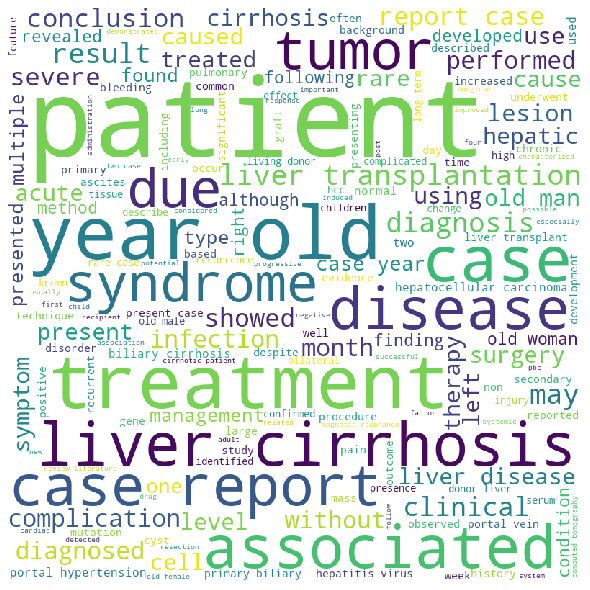

In [37]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

In [38]:
tokenizer.word_counts['patients']

1049

## Compare Group Frequencies

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
count_vec = CountVectorizer()
dfm_data = count_vec.fit_transform(clean_data_tr.txt)

dfm = pd.DataFrame(dfm_data.toarray(), columns = count_vec.get_feature_names())

In [41]:
dfm.head()

,03,05,08,10,11,12,13,14,15,16,...,zoonosis,zoonotic,zoster,zosteriform,zr,zurich,zygoma,zygomatic,zygomycetes,zygomycosis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
tokenizer.word_counts['zoonotic']

1

In [43]:
dfm.shape

(1289, 13660)

In [44]:
from sklearn import feature_selection

In [45]:
(chi_features_stat, chi_features_p) = feature_selection.chi2(dfm_data, clean_data.label)

In [46]:
np.where(dfm.columns == "liver")

(array([7150], dtype=int64),)

In [47]:
chi_features_stat[7452]

0.010922870615117992

In [48]:
chi_features_p[7452]

0.91676261882336

In [49]:
keyness_df = pd.DataFrame(dfm.columns,
                          columns=['term'])
keyness_df['chi2_stat'] = chi_features_stat
keyness_df['chi2_p'] = chi_features_p

In [50]:
keyness_df.sort_values(by='chi2_stat', ascending=False).head(19)

,term,chi2_stat,chi2_p
7150,liver,1605.464603,0.000000e+00
2097,cirrhosis,1032.533793,1.523015e-226
5570,hepatitis,378.819289,2.249166e-84
12695,transplantation,353.348847,7.904793e-79
9605,portal,330.205676,8.669436e-74
5563,hepatic,308.648696,4.301295e-69
1394,biliary,210.868673,8.878669e-48
3552,donor,181.208454,2.639797e-41
13256,vein,166.617678,4.054544e-38
9143,pbc,150.686767,1.227018e-34


In [51]:

keyness_df[
    [t in ("nerve", "melanoma", "sarcoma") for t in keyness_df.term]].sort_values(by = 'chi2_stat')

,term,chi2_stat,chi2_p
7545,melanoma,25.018786,5.677444e-07
11003,sarcoma,26.744220,2.322454e-07
8238,nerve,73.101548,1.231479e-17


In [52]:
case_rows = [l == 1 for l in clean_data.label]

np.mean(dfm.nerve[case_rows])

0.0016750418760469012

In [53]:
np.mean(dfm.nerve[np.logical_not(case_rows)])

0.12716763005780346

## Deep Learning

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
(X_train, X_test, y_train, y_test) =  train_test_split(
    clean_data.txt, clean_data.label, 
                            test_size = .3, stratify = clean_data.label)

In [56]:
seq_train = tokenizer.texts_to_sequences(X_train.values)
seq_test = tokenizer.texts_to_sequences(X_test.values)

In [57]:
maxlen = np.max(word_counts) + 1

In [58]:
maxlen

562

Vocab Size

In [59]:
len(tokenizer.word_index)

13853

In [60]:
X_train_pad = keras.preprocessing.sequence.pad_sequences(
    seq_train, maxlen=maxlen)
X_test_pad = keras.preprocessing.sequence.pad_sequences(
    seq_test, maxlen=maxlen)

Shape of data tensor

In [61]:
X_train_pad.shape

(902, 562)

In [62]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [63]:
np.unique(y_test)

array([0, 1], dtype=int64)

Comparable proportions

In [64]:
{i:np.sum(y_train == i) for i in (0, 1)}

{0: 484, 1: 418}

In [65]:
{i:np.sum(y_test == i) for i in (0, 1)}

{0: 208, 1: 179}

## No Pre-training

In [66]:
def buildCnn(EMBEDDING_DIM = 50,
                      num_filters = 100,
                      maxlen = 600,
                      vocab_size = 10000,
                      pre_trained = False,
                      embedding_matrix = None,
                      trainable_embed=True):
    
    hidden_dims = 128
    filt_sz = (3, 4, 5)
    
    drop_rate = 0.2

    inputs = keras.layers.Input(shape = [maxlen], name = "input")
    if(not pre_trained):
        embedding_lyr = p(inputs,
                          keras.layers.Embedding(input_dim = vocab_size,
                                                 output_dim = EMBEDDING_DIM,
                                                 input_length = maxlen,
                                                 name = "embed"),
                          keras.layers.Dropout(drop_rate, name = "drop1")
                         )
    else:
        embedding_lyr = p(inputs, 
                          keras.layers.Embedding(input_dim = vocab_size, 
                             output_dim = EMBEDDING_DIM, 
                             input_length = maxlen, 
                             trainable = trainable_embed, 
                             weights = embedding_matrix, 
                             name = "embed"),
                          layer_dropout(drop_rate, name = "drop1")
                         )
    
    # conv_ CNNs in parallel with different kernel sizes
    conv_1 = p(embedding_lyr, 
               keras.layers.Convolution1D(
                   num_filters, 
                   filt_sz[0], activation = "relu", name = "conv1"), 
               keras.layers.GlobalMaxPooling1D(name = "maxp1_glob")
              )
    
    conv_2 = p(embedding_lyr, 
               keras.layers.Convolution1D(
                   num_filters, 
                   filt_sz[1], activation = "relu", name = "conv2"), 
               keras.layers.GlobalMaxPooling1D(name = "maxp2_glob")
              )
    
    conv_3 = p(embedding_lyr, 
               keras.layers.Convolution1D(
                   num_filters, 
                   filt_sz[2], activation = "relu", name = "conv3"), 
               keras.layers.GlobalMaxPooling1D(name = "maxp3_glob")
              )
    
    merged_tensor = p(
        [conv_1, conv_2, conv_3],
        keras.layers.Concatenate(axis=1, name = "merged")
    )
    
    hidden = p(merged_tensor, 
             keras.layers.Dense(hidden_dims, 
                                activation = "relu", name = "hidden")
            )
    
    dropout = p(hidden, 
              keras.layers.Dropout(drop_rate, name = "drop2"), 
              keras.layers.Activation("relu", name = "activ_solo")
             )
    
    output = p(dropout, 
               keras.layers.Dense(1, activation = "sigmoid", name = "sigm"))
    
    model = keras.models.Model(inputs = inputs, 
                             outputs = output)
    
    # Compile model
    model.compile(
        loss = "binary_crossentropy",
        optimizer = "adam",
        metrics = ["accuracy"]
    )
    
    return(model)

## Build Model

In [90]:
model = buildCnn(EMBEDDING_DIM = 200, num_filters = 100, maxlen = 562, vocab_size = vocab_size)

In [91]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 562)          0                                            
__________________________________________________________________________________________________
embed (Embedding)               (None, 562, 200)     2770600     input[0][0]                      
__________________________________________________________________________________________________
drop1 (Dropout)                 (None, 562, 200)     0           embed[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 560, 100)     60100       drop1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

## Train

In [92]:
lr = .0004
epochs = 37#int(.015/lr)
batch_size = 32

keras.backend.set_value(model.optimizer.lr, lr)

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                               patience = 10)

import time
start_time = time.time()

history = model.fit(
    X_train_pad, y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [early_stopping],
    validation_split = 0.1
  )

print("Training time: %s" % (time.time() - start_time))

Train on 811 samples, validate on 91 samples
Epoch 1/37
811/811 [==============================] - 1s 2ms/step - loss: 0.6939 - acc: 0.5351 - val_loss: 0.6809 - val_acc: 0.5604
Epoch 2/37
811/811 [==============================] - 0s 329us/step - loss: 0.6637 - acc: 0.6338 - val_loss: 0.6397 - val_acc: 0.8242
Epoch 3/37
811/811 [==============================] - 0s 308us/step - loss: 0.5501 - acc: 0.8607 - val_loss: 0.4739 - val_acc: 0.9231
Epoch 4/37
811/811 [==============================] - 0s 328us/step - loss: 0.3106 - acc: 0.9260 - val_loss: 0.2517 - val_acc: 0.9231
Epoch 5/37
811/811 [==============================] - 0s 327us/step - loss: 0.1777 - acc: 0.9445 - val_loss: 0.2054 - val_acc: 0.9231
Epoch 6/37
811/811 [==============================] - 0s 310us/step - loss: 0.1382 - acc: 0.9531 - val_loss: 0.1836 - val_acc: 0.9341
Epoch 7/37
811/811 [==============================] - 0s 327us/step - loss: 0.1056 - acc: 0.9729 - val_loss: 0.1657 - val_acc: 0.9341
Epoch 8/37
811/811 

In [93]:
type(history)

keras.callbacks.History

In [94]:
type(history.history)

dict

In [95]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [96]:
from plot_keras_history import plot_history

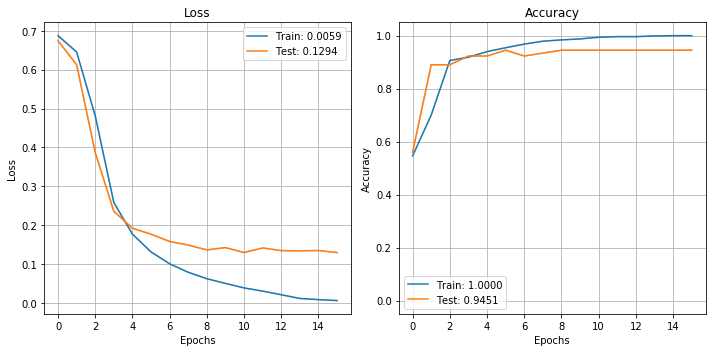

In [81]:
plot_history(history.history)

## Evaluate

In [82]:
type(batch_size)

int

In [83]:
scores = model.evaluate(X_test_pad, y_test, batch_size)

print('Test accuracy ' + str(scores[1]) + "\n")
# AUC
cnn_prob = model.predict(X_test_pad)

387/387 [==============================] - 0s 161us/step
Test accuracy 0.9405684754521964



In [84]:
scores[1]

0.9405684754521964

Confusion Matrix

In [85]:
pred_bin = cnn_prob > .5

# metrics
cm = mets.confusion_matrix(y_test, pred_bin)

def printMet(met_name, fn):
    print(met_name + ": " + str(fn(y_test, pred_bin)))

printMet("Accuracy", mets.accuracy_score)
printMet("Precision", mets.precision_score)
printMet("Recall", mets.recall_score)
printMet("F1", mets.f1_score)

Accuracy: 0.9405684754521964
Precision: 0.9534883720930233
Recall: 0.9162011173184358
F1: 0.9344729344729346


In [86]:
cm

array([[200,   8],
       [ 15, 164]], dtype=int64)

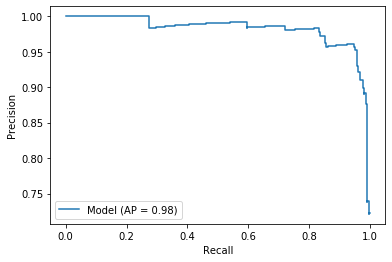

In [87]:
#Scikit-learn expects certain attributes for PR and AUROC plot
model._estimator_type = "classifier"
model.predict_proba = lambda X: np.concatenate( 
    (model.predict(X), 1-model.predict(X))
    , axis = 1)
model.classes_ = [1, 0]

mets.plot_precision_recall_curve(model, X_test_pad, y_test)

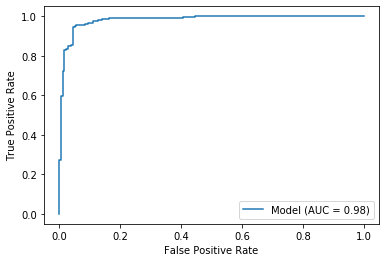

In [88]:
mets.plot_roc_curve(model, X_test_pad, y_test)